In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import colormaps  



In [2]:
import pandas as pd
from pathlib import Path

LOAD_PATH = Path("/root/capsule/scratch/all_tongue_movements/all_tongue_movements_16092025.parquet")

all_tongue_movements = pd.read_parquet(LOAD_PATH, engine="pyarrow")
print(all_tongue_movements.shape, all_tongue_movements.dtypes)

(40049, 45) movement_id                       Int64
start_time                      float64
end_time                        float64
duration                        float64
min_x                           float64
max_x                           float64
min_y                           float64
max_y                           float64
min_xv                          float64
max_xv                          float64
min_yv                          float64
max_yv                          float64
peak_velocity                   float64
mean_velocity                   float64
total_distance                  float64
startpoint_x                    float64
startpoint_y                    float64
endpoint_x                      float64
endpoint_y                      float64
time_to_endpoint                float64
excursion_angle_deg             float64
max_x_from_jaw                  float64
max_x_from_jaw_y                float64
max_y_from_jaw                  float64
max_y_from_jaw_x            

In [3]:
# LOAD INTERMEDIATE DATA

# # # User input: session folder
session_folder = "/root/capsule/scratch/session_analysis_in_distribution/behavior_716325_2024-05-31_10-31-14"

# Build paths
intermediate_dir = Path(session_folder) / "intermediate_data"
movements_path = intermediate_dir / "tongue_movs.parquet"
df_trials_path = intermediate_dir / "nwb_df_trials.parquet"
df_licks_path = intermediate_dir / "nwb_df_licks.parquet"

# Load dataframes
tongue_movements = pd.read_parquet(movements_path)
df_trials = pd.read_parquet(df_trials_path)
df_licks = pd.read_parquet(df_licks_path)


print(tongue_movements.columns)

Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'startpoint_x',
       'startpoint_y', 'endpoint_x', 'endpoint_y', 'time_to_endpoint',
       'excursion_angle_deg', 'max_x_from_jaw', 'max_x_from_jaw_y',
       'max_y_from_jaw', 'max_y_from_jaw_x', 'max_x_distance',
       'max_y_distance', 'n_datapoints', 'dropped_frames_n',
       'dropped_frames_pct', 'has_lick', 'first_lick_index', 'lick_count',
       'trial', 'cue_response', 'rewarded', 'event'],
      dtype='object')


In [4]:
# example: time of first tongue movement on each trial:
df = tongue_movements.copy()

# Get first start_time per trial
first_start_times = df.groupby('trial', as_index=False).nth(0)[['trial', 'start_time']]

print(first_start_times)


      trial   start_time
20      0.0     0.190304
48      1.0    13.650272
88      2.0    29.780192
142     3.0    63.880128
220     4.0   136.206016
...     ...          ...
7232  581.0  5291.530560
7236  582.0  5297.304576
7238  583.0  5307.098528
7240  584.0  5314.612512
7243  585.0  5321.664512

[568 rows x 2 columns]


In [5]:
# example: whether first tongue movement is a lick (would be a cue response lick)
# Group by trial and get the first movement row for each trial
df = tongue_movements.copy()

first_movements = df.groupby('trial').nth(0).reset_index()

# Select only the trial, has_lick, and cue_response columns
first_movement_licks = first_movements[['trial', 'has_lick', 'cue_response']]
print(first_movement_licks)
#NB: cue_response == None means there was no lick detected by lickometer.

# # Sanity check: Find rows where has_lick is False and cue_response is True (should never happen)
# violation_rows = first_movement_licks[(first_movement_licks['has_lick'] == False) & (first_movement_licks['cue_response'] == True)]
# print(violation_rows)


     trial  has_lick cue_response
0      0.0     False         None
1      1.0      True         True
2      2.0     False         None
3      3.0     False         None
4      4.0     False         None
..     ...       ...          ...
563  581.0      True         True
564  582.0      True         True
565  583.0      True         True
566  584.0      True         True
567  585.0      True         True

[568 rows x 3 columns]


In [6]:
# example analysis

from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import aggregate_tongue_movements, add_lick_metadata_to_movements, annotate_movement_timing

# Add lick time from licks_df
tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    df_licks,
    fields=['timestamps']
)
tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

# Annotate movements using trials
tongue_movements = annotate_movement_timing(tongue_movements, df_trials)


/src/aind-dynamic-foraging-behavior-video-analysis/src/aind_dynamic_foraging_behavior_video_analysis/kinematics/tongue_kinematics_utils.py:306: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[df['cue_response'].fillna(False)]


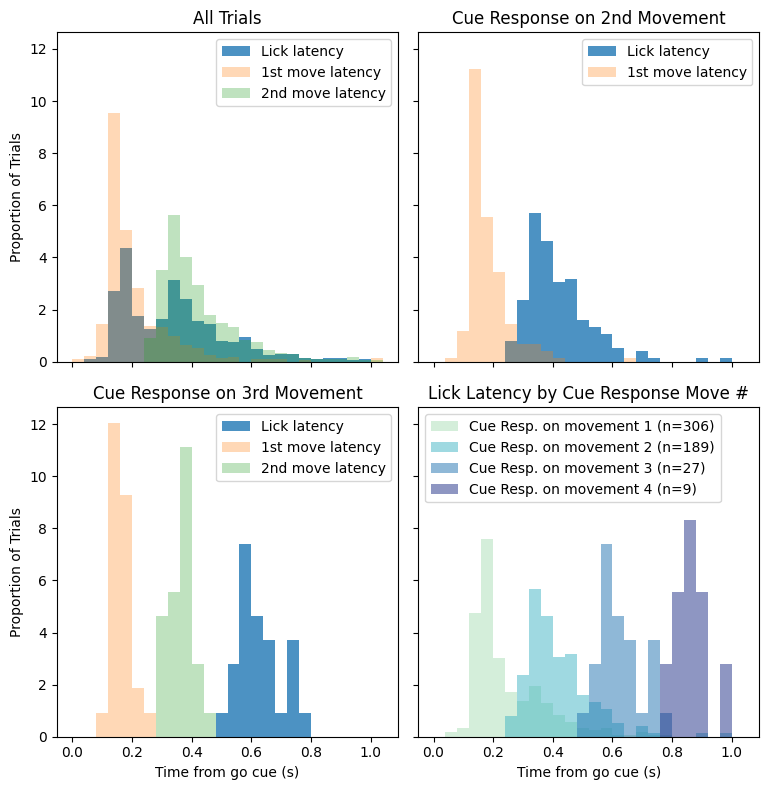

In [7]:
# plotting results: latency of cue response tongue movements, sorted by movement ordinal

# --- Shared settings ---
bins = np.arange(0, 1.05, 0.04)
colors = {
    "lick": "#1f77b4",
    "first": "#ff7f0e",
    "second": "#2ca02c",
}
alpha_lick = 0.8
alpha_move = 0.3

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.ravel()

# -------------------------------
# Subplot 1: All trials
# -------------------------------
df = tongue_movements.copy()

lick_lat = df.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)

first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[0]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
ax.set(title="All Trials", ylabel="Proportion of Trials")
ax.legend()

# -------------------------------
# Subplot 2: Cue response on 2nd movement
# -------------------------------
trials_2nd = df.loc[df['cue_response_movement_number'] == 2, 'trial'].unique()
df_2nd = df.query("trial in @trials_2nd and movement_number_in_trial <= 2")

lick_lat = df_2nd.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df_2nd[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)
first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']

ax = axes[1]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.set(title="Cue Response on 2nd Movement")
ax.legend()

# -------------------------------
# Subplot 3: Cue response on 3rd movement
# -------------------------------
trials_3rd = df.loc[df['cue_response_movement_number'] == 3, 'trial'].unique()
df_3rd = df.query("trial in @trials_3rd and movement_number_in_trial <= 3")

lick_lat = df_3rd.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df_3rd[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)
first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[2]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
ax.set(title="Cue Response on 3rd Movement", xlabel="Time from go cue (s)", ylabel="Proportion of Trials")
ax.legend()

# -------------------------------
# Subplot 4: Lick latency by cue_response_movement_number (1-4)
# -------------------------------
per_trial = (
    tongue_movements
      .dropna(subset=['lick_latency', 'cue_response_movement_number'])
      .drop_duplicates('trial')                # <- critical: keep a single row per trial
      .copy()
)
lick_latencies_by_cue = (
    per_trial
      .query("cue_response_movement_number <= 4")
      .groupby('cue_response_movement_number')['lick_latency']
      .apply(list)
      .to_dict()
)

cmap = plt.colormaps['YlGnBu']
colors = cmap(np.linspace(0.3, 0.9, 4))

ax = axes[3]
for n in sorted(lick_latencies_by_cue.keys()):
    latencies = lick_latencies_by_cue[n]
    ax.hist(
        latencies, bins=bins, density=True, alpha=0.5,
        label=f"Cue Resp. on movement {n} (n={len(latencies)})",
        color=colors[n-1]
    )
ax.set(title="Lick Latency by Cue Response Move #", xlabel="Time from go cue (s)")
ax.legend(loc="upper left")

# --- Final layout ---
fig.tight_layout()
plt.show()





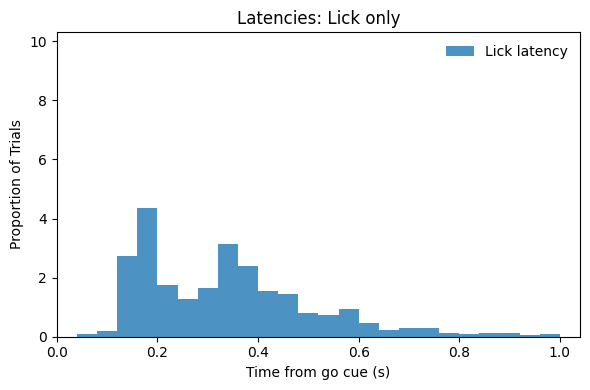

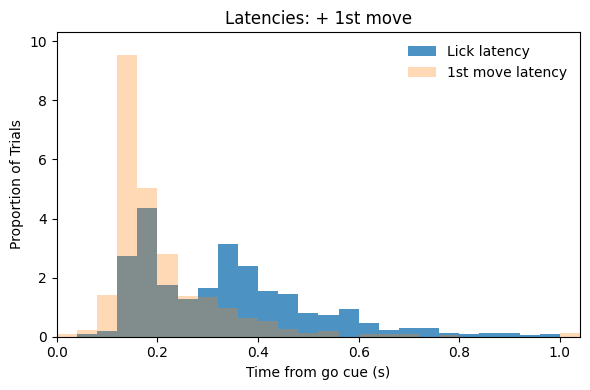

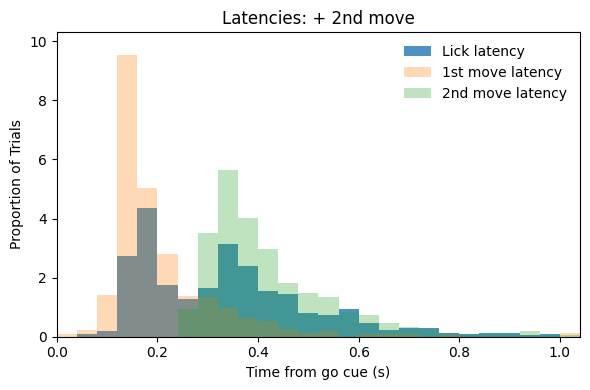

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- Settings (match your palette) ---
bins = np.arange(0, 1.05, 0.04)
colors = {
    "lick": "#1f77b4",
    "first": "#ff7f0e",
    "second": "#2ca02c",
}
alpha_lick = 0.8
alpha_move = 0.3
figsize = (6, 4)   # adjust as needed
xlabel = "Time from go cue (s)"
ylabel = "Proportion of Trials"
title_prefix = "Latencies"

# --- Extract latencies ---
df = tongue_movements.copy()

# Lick latency (one per trial)
lick_lat = (
    df.drop_duplicates('trial')['lick_latency']
      .dropna()
)

# Movement latencies ordered within each trial
moves = (
    df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)

first_move = (
    moves.groupby('trial')
         .nth(0)['movement_latency_from_go']
         .dropna()
)
second_move = (
    moves.groupby('trial')
         .nth(1)['movement_latency_from_go']
         .dropna()
)

# --- Compute shared axis limits ---
# Use density=True like the plots; take the max bin height across all three
def max_density(arr):
    if len(arr) == 0:
        return 0.0
    hist, _ = np.histogram(arr, bins=bins, density=True)
    return hist.max() if len(hist) else 0.0

ymax = max(
    max_density(lick_lat),
    max_density(first_move),
    max_density(second_move),
)
# Add a small headroom so the tallest bar doesn't touch the top
ymax = ymax * 1.08 if ymax > 0 else 1.0

xlim = (bins[0], bins[-1])
ylim = (0, ymax)

# --- Panel A: Lick latency only ---
figA, axA = plt.subplots(figsize=figsize)
axA.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
axA.set(xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=f"{title_prefix}: Lick only")
axA.legend(frameon=False)
figA.tight_layout()
# figA.savefig("panelA_lick_only.png", dpi=300, bbox_inches="tight")  # uncomment to save

# --- Panel B: + 1st move latency (superimposed) ---
figB, axB = plt.subplots(figsize=figsize)
axB.hist(lick_lat,   bins=bins, density=True, alpha=alpha_lick, color=colors["lick"],  label="Lick latency")
axB.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
axB.set(xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=f"{title_prefix}: + 1st move")
axB.legend(frameon=False)
figB.tight_layout()
# figB.savefig("panelB_lick_plus_first.png", dpi=300, bbox_inches="tight")  # uncomment to save

# --- Panel C: + 2nd move latency (superimposed) ---
figC, axC = plt.subplots(figsize=figsize)
axC.hist(lick_lat,    bins=bins, density=True, alpha=alpha_lick, color=colors["lick"],   label="Lick latency")
axC.hist(first_move,  bins=bins, density=True, alpha=alpha_move, color=colors["first"],  label="1st move latency")
axC.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
axC.set(xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=f"{title_prefix}: + 2nd move")
axC.legend(frameon=False)
figC.tight_layout()
# figC.savefig("panelC_lick_plus_first_second.png", dpi=300, bbox_inches="tight")  # uncomment to save


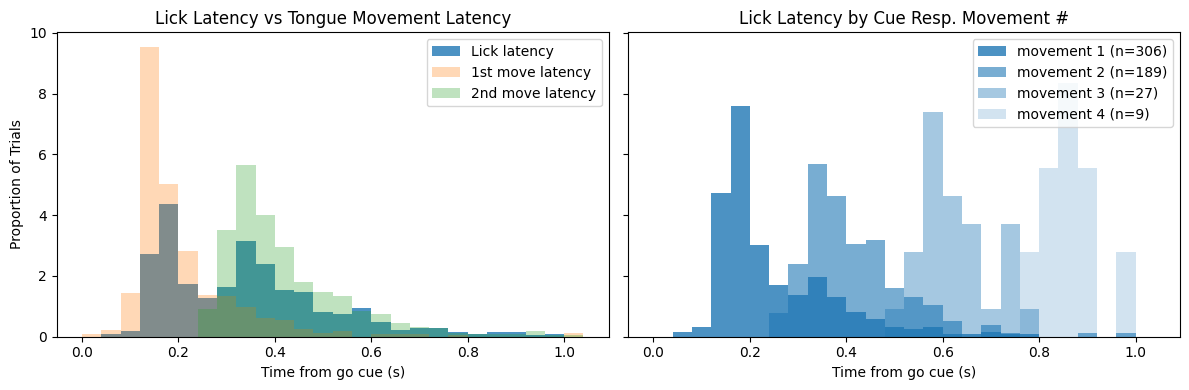

In [9]:
# --- Shared settings ---
bins = np.arange(0, 1.05, 0.04)
base_colors = {
    "lick": "#1f77b4",   # blue
    "first": "#ff7f0e",
    "second": "#2ca02c",
}
alpha_lick = 0.8
alpha_move = 0.3

# Make side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

# -------------------------------
# Panel 1: All trials (like old subplot 1)
# -------------------------------
df = tongue_movements.copy()

lick_lat = df.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)

first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[0]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=base_colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=base_colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=base_colors["second"], label="2nd move latency")
ax.set(title="Lick Latency vs Tongue Movement Latency", ylabel="Proportion of Trials", xlabel="Time from go cue (s)")
ax.legend()

# -------------------------------
# Panel 2: Lick latency by cue_response_movement_number (use one color, vary alpha)
# -------------------------------
# One lick per trial, then group
per_trial = (
    tongue_movements
      .dropna(subset=['lick_latency', 'cue_response_movement_number'])
      .drop_duplicates('trial')                # <- critical: keep a single row per trial
      .copy()
)
lick_latencies_by_cue = (
    per_trial
      .query("cue_response_movement_number <= 4")
      .groupby('cue_response_movement_number')['lick_latency']
      .apply(list)
      .to_dict()
)

# decreasing alpha with movement number
alphas = {1: 0.8, 2: 0.6, 3: 0.4, 4: 0.2}

ax = axes[1]
for n in sorted(lick_latencies_by_cue.keys()):
    latencies = lick_latencies_by_cue[n]
    ax.hist(
        latencies, bins=bins, density=True,
        alpha=alphas.get(n, 0.2),
        label=f"movement {n} (n={len(latencies)})",
        color=base_colors["lick"]
    )
ax.set(title="Lick Latency by Cue Resp. Movement #", xlabel="Time from go cue (s)")
ax.legend(loc="upper right")

# --- Final layout ---
fig.tight_layout()
plt.show()


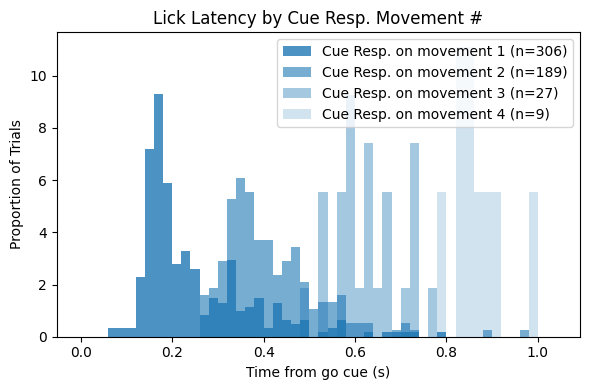

In [11]:
bins = np.arange(0, 1.05, 0.02)
lick_blue = "#1f77b4" 
alphas = {1: 0.8, 2: 0.6, 3: 0.4, 4: 0.2}

fig, ax = plt.subplots(figsize=(6, 4), sharex=True, sharey=True)
for n in sorted(lick_latencies_by_cue.keys()):
    latencies = lick_latencies_by_cue[n]
    ax.hist(
        latencies, bins=bins, density=True,
        alpha=alphas.get(n, 0.2),
        color=lick_blue,
        label=f"Cue Resp. on movement {n} (n={len(latencies)})"
    )
ax.set(title="Lick Latency by Cue Resp. Movement #", xlabel="Time from go cue (s)", ylabel="Proportion of Trials")
ax.legend(loc="upper right")
fig.tight_layout()
plt.show()


In [12]:
tongue_movements.columns

Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'startpoint_x',
       'startpoint_y', 'endpoint_x', 'endpoint_y', 'time_to_endpoint',
       'excursion_angle_deg', 'max_x_from_jaw', 'max_x_from_jaw_y',
       'max_y_from_jaw', 'max_y_from_jaw_x', 'max_x_distance',
       'max_y_distance', 'n_datapoints', 'dropped_frames_n',
       'dropped_frames_pct', 'has_lick', 'first_lick_index', 'lick_count',
       'trial', 'cue_response', 'rewarded', 'event', 'lick_time',
       'goCue_start_time_in_session', 'movement_number_in_trial',
       'cue_response_movement_number', 'movement_before_cue_response',
       'movement_latency_from_go', 'lick_latency'],
      dtype='object')

Δt (median inter-movement interval; k≤4): 0.20399999991059303
Global Kruskal–Wallis: H=8.756, p=0.0327
Density similarity vs k=1 (Spearman, Pearson):
  k=2: spearman=0.621, pearson=1.000
  k=3: spearman=0.541, pearson=0.979
  k=4: spearman=0.405, pearson=0.923
Reconstruction fit (symmetric KL, Wasserstein): {'symmetric_KL': 0.15400984025011194, 'wasserstein': 0.12234229187551475}
Mixture weights w_k (k≤4): {1: 0.5762711864406781, 2: 0.35593220338983056, 3: 0.050847457627118654, 4: 0.016949152542372885}
Mode regression (slope≈Δt, R²): {'slope': 0.17859704631179077, 'intercept': 0.000295809678761429, 'r2': 1.0}


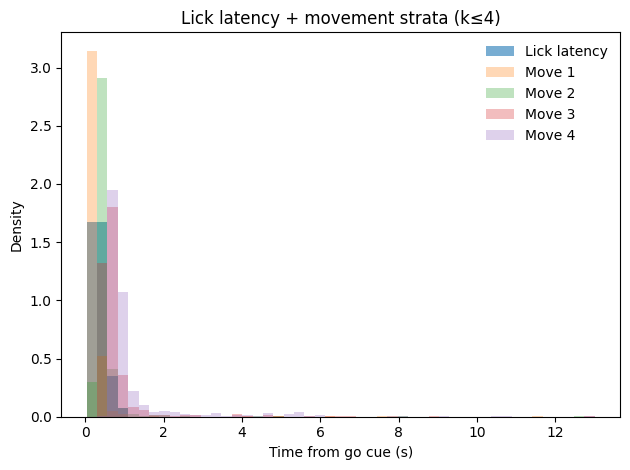

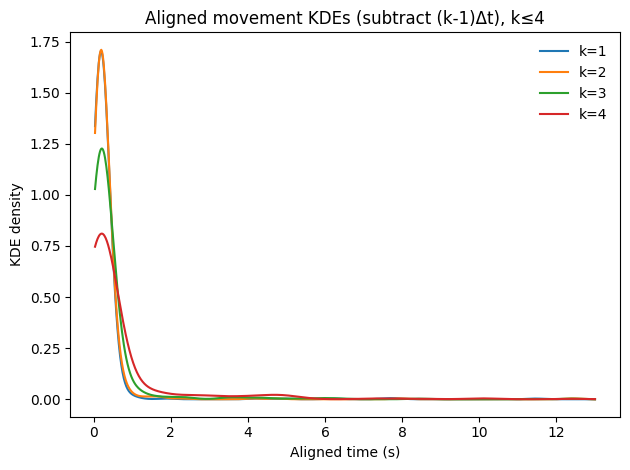

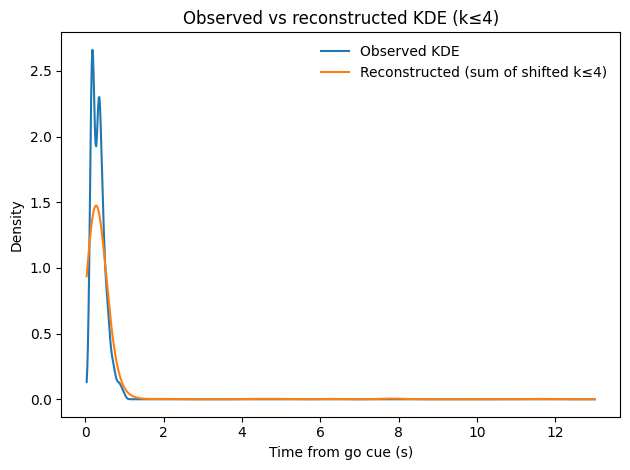

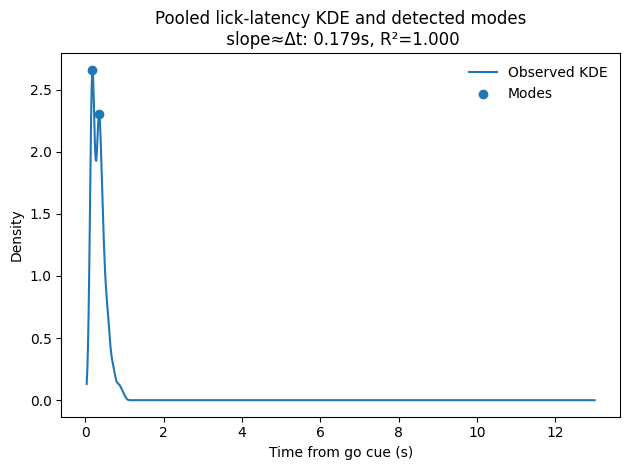

In [23]:
# === Lick-latency analysis limited to first four movements (k <= 4) ===
# Assumes a DataFrame `tongue_movements` with:
# ['trial','movement_number_in_trial','movement_latency_from_go','lick_latency', ...]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Dict, Tuple

from scipy.stats import gaussian_kde, ks_2samp, cramervonmises_2samp, kruskal, wasserstein_distance
from scipy.signal import find_peaks

MAX_K = 4  # <<< Only include movements up to this index

# -------------------------
# Utility / helper functions
# -------------------------

def _check_columns(df: pd.DataFrame, required):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in df: {missing}")

def _filtered_df_k_leq(df: pd.DataFrame, max_k: int) -> pd.DataFrame:
    """Filter to movements with movement_number_in_trial <= max_k."""
    _check_columns(df, ['movement_number_in_trial'])
    return df[df['movement_number_in_trial'].astype('Int64') <= max_k].copy()

def extract_stratified_latencies(df: pd.DataFrame, max_k: int) -> Dict[int, np.ndarray]:
    _check_columns(df, ['trial', 'movement_number_in_trial', 'movement_latency_from_go'])
    sub = _filtered_df_k_leq(df, max_k)
    sub = sub.dropna(subset=['movement_latency_from_go', 'movement_number_in_trial'])
    sub = sub.sort_values(['trial','movement_number_in_trial'])
    grouped = sub.groupby('movement_number_in_trial')['movement_latency_from_go']
    return {int(k): pd.to_numeric(v, errors="coerce").dropna().to_numpy() for k, v in grouped}

def extract_lick_latencies(df: pd.DataFrame) -> np.ndarray:
    _check_columns(df, ['trial', 'lick_latency'])
    per_trial = df.drop_duplicates('trial')
    return pd.to_numeric(per_trial['lick_latency'], errors="coerce").dropna().to_numpy()

def estimate_delta_t(df: pd.DataFrame, max_k: int) -> float:
    """Median within-trial first diffs, restricted to k<=max_k."""
    _check_columns(df, ['trial','movement_number_in_trial','movement_latency_from_go'])
    mv = _filtered_df_k_leq(df, max_k)
    mv = mv.dropna(subset=['movement_latency_from_go','movement_number_in_trial']) \
           .sort_values(['trial','movement_number_in_trial'])
    mv['movement_latency_from_go'] = pd.to_numeric(mv['movement_latency_from_go'], errors="coerce")
    diffs = (mv.groupby('trial')['movement_latency_from_go']
               .apply(lambda x: np.diff(pd.to_numeric(x, errors="coerce").dropna().to_numpy())))
    diffs_cat = np.concatenate([d for d in diffs.values if len(d) > 0]) if len(diffs) else np.array([])
    if diffs_cat.size == 0:
        raise ValueError("Could not estimate Δt; need at least two movements (k<=%d) in some trials." % max_k)
    return float(np.median(diffs_cat))

def align_by_shift(strata: Dict[int, np.ndarray], delta_t: float) -> Dict[int, np.ndarray]:
    return {k: (arr - (k-1)*delta_t) for k, arr in strata.items()}

def kde_on_grid(data: np.ndarray, grid: np.ndarray, bandwidth: Optional[float] = None) -> np.ndarray:
    data = np.asarray(data)
    if data.size < 2 or np.std(data) == 0:
        return np.zeros_like(grid, dtype=float)
    kde = gaussian_kde(dataset=data, bw_method=bandwidth)
    return kde(grid)

def pairwise_tests_aligned(aligned: Dict[int, np.ndarray]) -> Dict[Tuple[int,int], Dict[str, float]]:
    keys = sorted([k for k in aligned.keys() if aligned[k].size >= 2])
    out: Dict[Tuple[int,int], Dict[str, float]] = {}
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            ki, kj = keys[i], keys[j]
            xi = aligned[ki][~np.isnan(aligned[ki])]
            xj = aligned[kj][~np.isnan(aligned[kj])]
            if xi.size >= 2 and xj.size >= 2:
                ks = ks_2samp(xi, xj, alternative='two-sided', mode='auto')
                cvm = cramervonmises_2samp(xi, xj)
                out[(ki,kj)] = {'ks_stat': float(ks.statistic), 'ks_p': float(ks.pvalue),
                                'cvm_stat': float(cvm.statistic), 'cvm_p': float(cvm.pvalue)}
    return out

def global_kruskal(aligned: Dict[int, np.ndarray]) -> Tuple[float, float]:
    arrays = [v[~np.isnan(v)] for v in aligned.values() if np.sum(~np.isnan(v)) >= 2]
    if len(arrays) < 2:
        return np.nan, np.nan
    stat, p = kruskal(*arrays)
    return float(stat), float(p)

def density_similarity_vs_first(aligned: Dict[int, np.ndarray], grid: np.ndarray) -> Dict[int, Dict[str, float]]:
    sims: Dict[int, Dict[str, float]] = {}
    if 1 not in aligned:
        return sims
    base = kde_on_grid(aligned[1], grid)
    for k, arr in aligned.items():
        if k == 1: 
            continue
        y = kde_on_grid(arr, grid)
        if (np.std(base) > 0) and (np.std(y) > 0):
            pearson_r = np.corrcoef(base, y)[0,1]
        else:
            pearson_r = np.nan
        base_rank = pd.Series(base).rank().to_numpy()
        y_rank    = pd.Series(y).rank().to_numpy()
        if (np.std(base_rank) > 0) and (np.std(y_rank) > 0):
            spearman_r = np.corrcoef(base_rank, y_rank)[0,1]
        else:
            spearman_r = np.nan
        sims[k] = {'pearson_r': float(pearson_r), 'spearman_r': float(spearman_r)}
    return sims

def infer_lick_movement_numbers(df: pd.DataFrame, delta_t: float, max_k: int) -> pd.Series:
    """Infer k for the lick per trial, but only allow k<=max_k; drop trials outside tolerance."""
    _check_columns(df, ['trial','movement_number_in_trial','movement_latency_from_go','lick_latency'])
    df_t = df.dropna(subset=['lick_latency']).drop_duplicates('trial')[['trial','lick_latency']].set_index('trial')
    df_t['lick_latency'] = pd.to_numeric(df_t['lick_latency'], errors="coerce")
    mv = _filtered_df_k_leq(df, max_k)
    mv = mv.dropna(subset=['movement_latency_from_go','movement_number_in_trial']) \
           .sort_values(['trial','movement_number_in_trial']) \
           [['trial','movement_number_in_trial','movement_latency_from_go']]
    mv['movement_latency_from_go'] = pd.to_numeric(mv['movement_latency_from_go'], errors="coerce")
    ks = {}
    for trial, row in df_t.iterrows():
        lick = row['lick_latency']
        if pd.isna(lick):
            continue
        sub = mv[mv['trial'] == trial]
        if sub.empty:
            continue
        diffs = np.abs(sub['movement_latency_from_go'].to_numpy() - lick)
        idx = int(np.argmin(diffs))
        # Accept only if within Δt/2
        if diffs[idx] <= (delta_t/2.0):
            k_val = int(sub['movement_number_in_trial'].to_numpy()[idx])
            if k_val <= max_k:
                ks[trial] = k_val
    return pd.Series(ks, name='lick_movement_k')

def weights_from_inferred_k(lick_k: pd.Series, max_k: int) -> Dict[int, float]:
    """Normalize weights after truncating to k<=max_k."""
    if lick_k is None or lick_k.empty:
        return {}
    lick_k = lick_k[lick_k <= max_k]
    counts = lick_k.value_counts().sort_index()
    total = counts.sum()
    if total == 0:
        return {}
    w = {int(k): float(v/total) for k, v in counts.items()}
    # Ensure all k in 1..max_k appear (zero if absent)
    for k in range(1, max_k+1):
        if k not in w:
            w[k] = 0.0
    # Re-normalize to sum to 1 in case we force zeros
    s = sum(w.values())
    if s > 0:
        for k in w:
            w[k] /= s
    return w

def reconstruct_lick_density_from_first(first_move: np.ndarray,
                                        weights: Dict[int, float],
                                        delta_t: float,
                                        grid: np.ndarray,
                                        bandwidth: Optional[float] = None) -> np.ndarray:
    recon = np.zeros_like(grid, dtype=float)
    for k, w in sorted(weights.items()):
        shift = (k - 1) * delta_t
        contrib = kde_on_grid(first_move, grid - shift, bandwidth=bandwidth)
        recon += w * contrib
    return recon

def kl_divergence(p: np.ndarray, q: np.ndarray, eps: float = 1e-9) -> float:
    p = np.clip(p, eps, None); q = np.clip(q, eps, None)
    p = p / p.sum(); q = q / q.sum()
    return float(np.sum(p * np.log(p / q)))

def kde_vs_hist_distance(observed: np.ndarray,
                         predicted_density: np.ndarray,
                         grid: np.ndarray) -> Dict[str, float]:
    bins = np.linspace(grid.min(), grid.max(), 60)
    obs_hist, _  = np.histogram(observed, bins=bins, density=False)
    pred_counts  = np.maximum((predicted_density * 1000).astype(int), 0)
    pred_samples = np.repeat(grid, pred_counts)
    pred_hist, _ = np.histogram(pred_samples, bins=bins, density=False)
    obs_hist = obs_hist.astype(float) + 1e-9
    pred_hist = pred_hist.astype(float) + 1e-9
    obs_hist /= obs_hist.sum(); pred_hist /= pred_hist.sum()
    skl = 0.5*(kl_divergence(obs_hist, pred_hist) + kl_divergence(pred_hist, obs_hist))
    wdist = np.nan if (pred_samples.size == 0 or observed.size == 0) else float(wasserstein_distance(observed, pred_samples))
    return {'symmetric_KL': float(skl), 'wasserstein': float(wdist)}

def find_modes_from_kde(data: np.ndarray, grid: np.ndarray, prominence: float = 0.0):
    y = kde_on_grid(data, grid)
    if np.allclose(y, 0):
        return np.array([]), np.array([])
    peaks, props = find_peaks(y, prominence=prominence)
    return grid[peaks], y[peaks]

def regress_mode_positions(mode_locs: np.ndarray) -> Dict[str, float]:
    if mode_locs.size < 2:
        return {'slope': np.nan, 'intercept': np.nan, 'r2': np.nan}
    k = np.arange(1, len(mode_locs) + 1)
    slope, intercept = np.polyfit(k, mode_locs, 1)
    yhat = slope * k + intercept
    ss_res = float(np.sum((mode_locs - yhat)**2))
    ss_tot = float(np.sum((mode_locs - mode_locs.mean())**2))
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return {'slope': float(slope), 'intercept': float(intercept), 'r2': float(r2)}

# -----------------
# Plotting helpers
# -----------------

def plot_histograms(lick_lat: np.ndarray, strata: Dict[int, np.ndarray], bins: np.ndarray,
                    title: str = "Lick latency + movement strata (hist)"):
    fig, ax = plt.subplots()
    if lick_lat.size > 0:
        ax.hist(lick_lat, bins=bins, density=True, alpha=0.6, label="Lick latency")
    for k in sorted([kk for kk in strata.keys() if kk <= MAX_K]):
        arr = strata[k]
        if arr.size > 0:
            ax.hist(arr, bins=bins, density=True, alpha=0.3, label=f"Move {k}")
    ax.set_xlabel("Time from go cue (s)"); ax.set_ylabel("Density"); ax.set_title(title)
    ax.legend(frameon=False); fig.tight_layout()

def plot_aligned_kdes(aligned: Dict[int, np.ndarray], grid: np.ndarray,
                      title: str = "Aligned movement KDEs (subtract (k-1)Δt)"):
    fig, ax = plt.subplots()
    for k in sorted([kk for kk in aligned.keys() if kk <= MAX_K]):
        y = kde_on_grid(aligned[k], grid)
        ax.plot(grid, y, label=f"k={k}")
    ax.set_xlabel("Aligned time (s)"); ax.set_ylabel("KDE density"); ax.set_title(title)
    ax.legend(frameon=False); fig.tight_layout()

def plot_reconstruction_vs_observed(lick_lat: np.ndarray,
                                    recon_density: np.ndarray,
                                    grid: np.ndarray,
                                    title: str = "Observed vs reconstructed lick-latency KDE"):
    fig, ax = plt.subplots()
    obs = kde_on_grid(lick_lat, grid)
    ax.plot(grid, obs, label="Observed KDE")
    ax.plot(grid, recon_density, label=f"Reconstructed (sum of shifted k≤{MAX_K})")
    ax.set_xlabel("Time from go cue (s)"); ax.set_ylabel("Density"); ax.set_title(title)
    ax.legend(frameon=False); fig.tight_layout()

def plot_modes_and_fit(lick_lat: np.ndarray, grid: np.ndarray,
                       title: str = "Pooled lick-latency KDE and detected modes"):
    fig, ax = plt.subplots()
    kde = kde_on_grid(lick_lat, grid)
    ax.plot(grid, kde, label="Observed KDE")
    peaks_x, peaks_y = find_modes_from_kde(lick_lat, grid)
    if peaks_x.size > 0:
        ax.scatter(peaks_x, peaks_y, marker='o', label="Modes")
        fit = regress_mode_positions(peaks_x)
        ax.set_title(f"{title}\n slope≈Δt: {fit['slope']:.3f}s, R²={fit['r2']:.3f}")
    else:
        fit = {'slope': np.nan, 'intercept': np.nan, 'r2': np.nan}
        ax.set_title(title)
    ax.set_xlabel("Time from go cue (s)"); ax.set_ylabel("Density"); ax.legend(frameon=False); fig.tight_layout()
    return fit

# -----------------
# Run full analysis
# -----------------

def run_full_analysis(
    tongue_movements: pd.DataFrame,
    grid_min: Optional[float] = None,
    grid_max: Optional[float] = None,
    grid_n: int = 800,
    bins: Optional[np.ndarray] = None,
    kde_bandwidth: Optional[float] = None,
    mode_prominence: float = 0.0,
    max_k: int = MAX_K,
):
    # 1) Extract (k<=max_k)
    strata = extract_stratified_latencies(tongue_movements, max_k=max_k)
    lick_lat = extract_lick_latencies(tongue_movements)

    # Grid & bins
    arrays = [a for a in list(strata.values()) + [lick_lat] if a.size > 0]
    data_min = float(np.min([np.min(a) for a in arrays]))
    data_max = float(np.max([np.max(a) for a in arrays]))
    gmin = float(data_min if grid_min is None else grid_min)
    gmax = float(data_max if grid_max is None else grid_max)
    grid = np.linspace(gmin, gmax, grid_n)
    if bins is None:
        bins = np.linspace(gmin, gmax, 50)

    # 2) Δt from k<=max_k
    delta_t = estimate_delta_t(tongue_movements, max_k=max_k)

    # 3) Align
    aligned = align_by_shift(strata, delta_t)

    # 4) Tests
    pw = pairwise_tests_aligned(aligned)
    gstat, gp = global_kruskal(aligned)
    dens_sim = density_similarity_vs_first(aligned, grid)

    # 5) Reconstruction using k<=max_k
    first = strata.get(1, np.array([]))
    lick_k = infer_lick_movement_numbers(tongue_movements, delta_t, max_k=max_k)
    weights = weights_from_inferred_k(lick_k, max_k=max_k)
    recon = reconstruct_lick_density_from_first(first, weights, delta_t, grid, bandwidth=kde_bandwidth)
    recon_metrics = kde_vs_hist_distance(lick_lat, recon, grid)

    # 6) Modes
    peaks_x, _ = find_modes_from_kde(lick_lat, grid, prominence=mode_prominence)
    mode_fit = regress_mode_positions(peaks_x)

    # 7) Plots
    plot_histograms(lick_lat, strata, bins, title=f"Lick latency + movement strata (k≤{max_k})")
    plot_aligned_kdes(aligned, grid, title=f"Aligned movement KDEs (subtract (k-1)Δt), k≤{max_k}")
    plot_reconstruction_vs_observed(lick_lat, recon, grid, title=f"Observed vs reconstructed KDE (k≤{max_k})")
    _ = plot_modes_and_fit(lick_lat, grid, title="Pooled lick-latency KDE and detected modes")

    return {
        'delta_t': delta_t,
        'pairwise_tests': pw,
        'global_kruskal_stat': gstat,
        'global_kruskal_p': gp,
        'density_similarity': dens_sim,
        'reconstruction_metrics': recon_metrics,
        'mode_regression': mode_fit,
        'weights': weights,
        'aligned_preview': aligned,
        'grid': grid
    }

# -----------------
# Execute on your df
# -----------------

GRID_MIN = None   # e.g., 0.0
GRID_MAX = None   # e.g., 1.05
BINS = None       # or np.arange(0, 1.05, 0.04)

results = run_full_analysis(
    tongue_movements,
    grid_min=GRID_MIN, grid_max=GRID_MAX,
    bins=BINS,
    kde_bandwidth=None,
    mode_prominence=0.0,
    max_k=MAX_K,
)

print("Δt (median inter-movement interval; k≤%d):" % MAX_K, results['delta_t'])
print("Global Kruskal–Wallis: H=%.3f, p=%.3g" % (results['global_kruskal_stat'], results['global_kruskal_p']))
print("Density similarity vs k=1 (Spearman, Pearson):")
for k, d in sorted(results['density_similarity'].items()):
    print(f"  k={k}: spearman={d['spearman_r']:.3f}, pearson={d['pearson_r']:.3f}")
print("Reconstruction fit (symmetric KL, Wasserstein):", results['reconstruction_metrics'])
print("Mixture weights w_k (k≤%d):" % MAX_K, results['weights'])
print("Mode regression (slope≈Δt, R²):", results['mode_regression'])


Rows before: 7258  | after filter: 806
Unique trials after filter: 532



Δt (median inter-movement interval on filtered data): 0.20198399992659688
Global Kruskal–Wallis: H=7.808, p=0.0502
Density similarity vs k=1 (Spearman, Pearson):
  k=2: spearman=0.980, pearson=0.959
  k=3: spearman=0.985, pearson=0.882
  k=4: spearman=0.975, pearson=0.710
Reconstruction fit (symmetric KL, Wasserstein): {'symmetric_KL': 0.28277696435881106, 'wasserstein': 0.03332572800695764}
Mixture weights w_k (inferred from cue-response-limited data): {1: 0.5762711864406781, 2: 0.35593220338983056, 3: 0.050847457627118654, 4: 0.016949152542372885}
Mode regression (slope≈Δt, R²): {'slope': 0.16809251563896288, 'intercept': 0.01355742670138741, 'r2': 1.0}


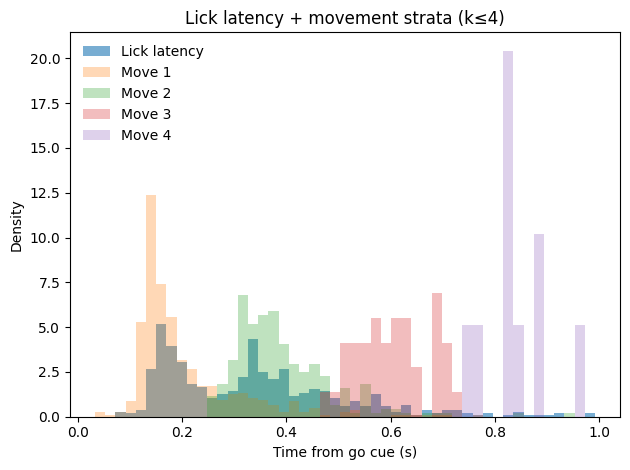

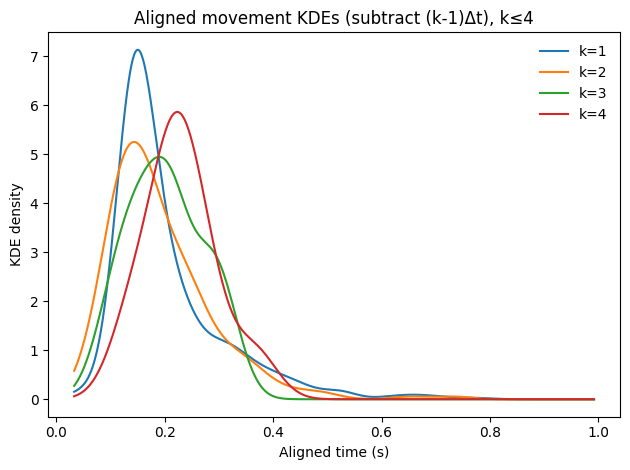

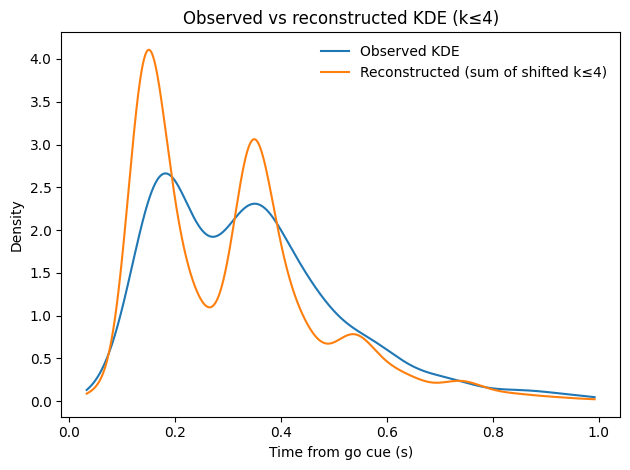

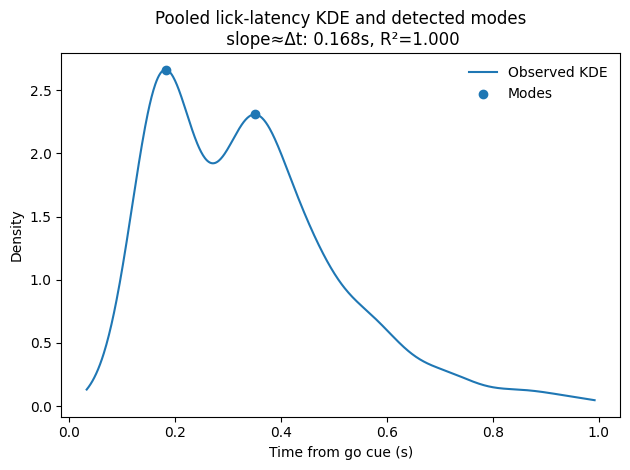

In [24]:
# --- Filter to movements up to (and including) the cue-response movement, per trial ---
tm = tongue_movements.copy()

# Be robust to pandas' nullable dtypes
tm['movement_number_in_trial'] = pd.to_numeric(tm['movement_number_in_trial'], errors='coerce')
tm['cue_response_movement_number'] = pd.to_numeric(tm['cue_response_movement_number'], errors='coerce')

# Keep rows where cue_response_movement_number exists AND movement_number_in_trial <= it
mask = tm['cue_response_movement_number'].notna() & (
    tm['movement_number_in_trial'] <= tm['cue_response_movement_number']
)
tm_filt = tm[mask].copy()

print("Rows before:", len(tongue_movements), " | after filter:", len(tm_filt))
print("Unique trials after filter:", tm_filt['trial'].nunique())

# --- Re-run the analysis on the filtered dataframe (uses your previously-defined run_full_analysis) ---
results_cr = run_full_analysis(
    tm_filt,
    grid_min=None,     # or set your preferred range, e.g., 0.0
    grid_max=None,     # e.g., 1.05
    bins=None,         # or np.arange(0, 1.05, 0.04)
    kde_bandwidth=None,
    mode_prominence=0.0
)

print("\nΔt (median inter-movement interval on filtered data):", results_cr['delta_t'])
print("Global Kruskal–Wallis: H=%.3f, p=%.3g" % (results_cr['global_kruskal_stat'], results_cr['global_kruskal_p']))
print("Density similarity vs k=1 (Spearman, Pearson):")
for k, d in sorted(results_cr['density_similarity'].items()):
    print(f"  k={k}: spearman={d['spearman_r']:.3f}, pearson={d['pearson_r']:.3f}")
print("Reconstruction fit (symmetric KL, Wasserstein):", results_cr['reconstruction_metrics'])
print("Mixture weights w_k (inferred from cue-response-limited data):", results_cr['weights'])
print("Mode regression (slope≈Δt, R²):", results_cr['mode_regression'])


Using k = 1..5 components; weights: {1: 0.575187969924812, 2: 0.35526315789473684, 3: 0.05075187969924812, 4: 0.016917293233082706, 5: 0.0018796992481203006}
Symmetric KL (obs vs recon): 1.0816
Wasserstein distance (s):    0.0159


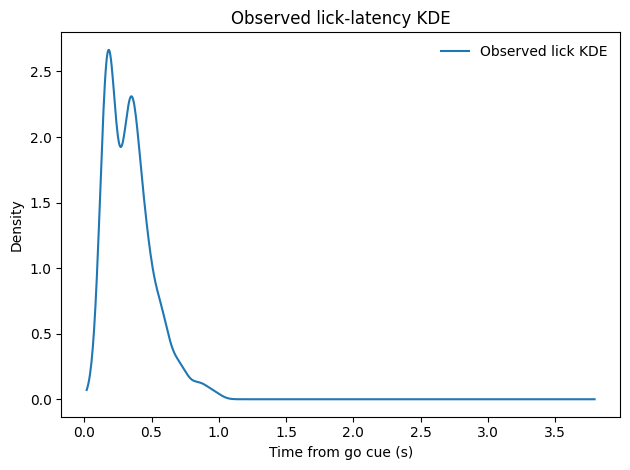

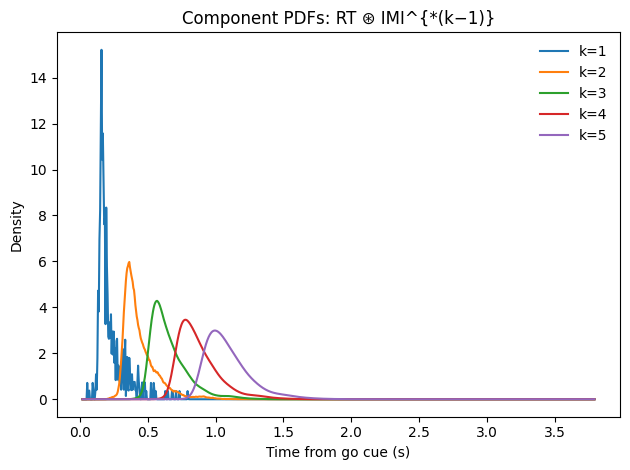

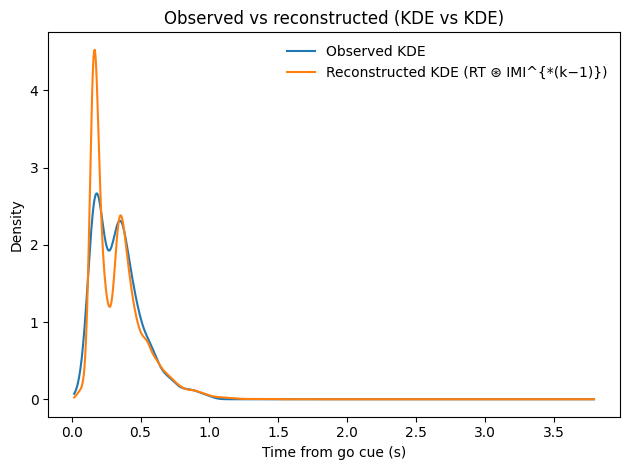

In [22]:
# === RT + repeated-IMI reconstruction of lick latency (aliasing + smoothing equalized) ===
# Requires DataFrame `tongue_movements` with:
# ['trial','movement_number_in_trial','movement_latency_from_go','lick_latency','cue_response_movement_number']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Dict
from scipy.stats import gaussian_kde, wasserstein_distance

# ---------- Helpers ----------
def _check_cols(df, cols):
    miss = [c for c in cols if c not in df.columns]
    if miss:
        raise ValueError(f"Missing columns: {miss}")

def kde_on_grid(samples: np.ndarray, grid: np.ndarray, bw: Optional[float]=None) -> np.ndarray:
    samples = np.asarray(samples)
    if samples.size < 2 or np.std(samples) == 0:
        return np.zeros_like(grid, dtype=float)
    kde = gaussian_kde(samples, bw_method=bw)
    y = kde(grid)
    # normalize numerically to integrate to 1 over grid spacing
    dx = grid[1]-grid[0] if len(grid) > 1 else 1.0
    s = y.sum() * dx
    return (y / s) if s > 0 else y

def pdf_from_hist(samples: np.ndarray, grid_min: float, grid_max: float, dx: float):
    """Histogram-based PDF on a fixed grid; returns (pdf, centers)."""
    if grid_max <= grid_min:
        raise ValueError("grid_max must be > grid_min")
    bins = np.arange(grid_min, grid_max + dx, dx)
    hist, edges = np.histogram(samples, bins=bins, density=False)
    centers = 0.5 * (edges[:-1] + edges[1:])
    pdf = hist.astype(float)
    s = pdf.sum()
    if s > 0:
        pdf = pdf / (s * dx)   # density normalization
    else:
        pdf = np.zeros_like(centers)
    return pdf, centers

def place_pdf_on_grid_linear(x_centers: np.ndarray, pdf_vals: np.ndarray, grid: np.ndarray, dx: float) -> np.ndarray:
    """
    Place a continuous PDF (given at 'x_centers') onto a uniform 'grid' using linear interpolation
    (distributes mass to the two nearest bins), avoiding rounding spikes. Returns a density on 'grid'.
    """
    out = np.zeros_like(grid, dtype=float)
    fidx = (x_centers - grid[0]) / dx          # fractional bin index
    i0 = np.floor(fidx).astype(int)
    w1 = fidx - i0
    i1 = i0 + 1
    ok0 = (i0 >= 0) & (i0 < len(grid))
    ok1 = (i1 >= 0) & (i1 < len(grid))
    # move *mass* per bin first (pdf * dx), then renormalize to density
    mass = pdf_vals * dx
    np.add.at(out, i0[ok0], mass[ok0] * (1 - w1[ok0]))
    np.add.at(out, i1[ok1], mass[ok1] * (w1[ok1]))
    # back to density
    s = out.sum() * dx
    return (out / s) if s > 0 else out

def fft_convolve(pdf_a: np.ndarray, pdf_b: np.ndarray, dx: float) -> np.ndarray:
    """Convolution of two discrete PDFs (densities) on same dx. Returns density with correct scaling."""
    n = int(2**np.ceil(np.log2(len(pdf_a) + len(pdf_b) - 1)))
    Fa = np.fft.rfft(pdf_a, n=n)
    Fb = np.fft.rfft(pdf_b, n=n)
    conv = np.fft.irfft(Fa * Fb, n=n)
    conv = conv * dx  # ensure unit mass since sum(pdf)*dx=1
    conv = conv[:(len(pdf_a) + len(pdf_b) - 1)]
    # renormalize
    s = conv.sum() * dx
    return (conv / s) if s > 0 else conv

def nfold_convolution(pdf: np.ndarray, n: int, dx: float) -> np.ndarray:
    if n <= 1:
        return pdf.copy()
    out = pdf.copy()
    for _ in range(n-1):
        out = fft_convolve(out, pdf, dx)
    return out

def symmetric_KL(p: np.ndarray, q: np.ndarray, eps: float=1e-12) -> float:
    p = np.clip(p, eps, None); q = np.clip(q, eps, None)
    p = p / p.sum(); q = q / q.sum()
    return 0.5 * (np.sum(p * np.log(p / q)) + np.sum(q * np.log(q / p)))

def sample_from_pdf(grid: np.ndarray, pdf: np.ndarray, n: int) -> np.ndarray:
    p = np.clip(pdf, 0, None)
    s = p.sum()
    if s == 0:
        return np.array([])
    p = p / s
    idx = np.random.choice(len(grid), size=n, replace=True, p=p)
    return grid[idx]

# ---------- Data prep: limit movements up to cue-response per trial ----------
tm = tongue_movements.copy()
_check_cols(tm, ['trial','movement_number_in_trial','movement_latency_from_go','lick_latency','cue_response_movement_number'])

for c in ['movement_number_in_trial','movement_latency_from_go','lick_latency','cue_response_movement_number']:
    tm[c] = pd.to_numeric(tm[c], errors='coerce')

mask = tm['cue_response_movement_number'].notna() & (tm['movement_number_in_trial'] <= tm['cue_response_movement_number'])
tm_filt = tm[mask].copy()

# RT samples (movement 1 latency from go)
rt = (tm_filt.query("movement_number_in_trial == 1")['movement_latency_from_go']
      .dropna().to_numpy())

# IMI samples (within-trial successive diffs) up to cue-response
imis = []
for trial, sub in (tm_filt.dropna(subset=['movement_latency_from_go','movement_number_in_trial'])
                          .sort_values(['trial','movement_number_in_trial'])
                          .groupby('trial')):
    lat = sub['movement_latency_from_go'].to_numpy()
    if lat.size >= 2:
        d = np.diff(lat)
        d = d[np.isfinite(d) & (d > 0)]
        if d.size:
            imis.append(d)
imis = np.concatenate(imis) if len(imis) else np.array([])

# Observed lick latency (one per trial)
lick_lat = tm.drop_duplicates('trial')['lick_latency'].dropna().to_numpy()

# Weights w_k from cue_response_movement_number per trial
cr_k = tm.drop_duplicates('trial')['cue_response_movement_number'].dropna().astype(int)
max_k = int(cr_k.max())
counts = cr_k.value_counts().sort_index()
w = {int(k): float(counts.get(k, 0)/counts.sum()) for k in range(1, max_k+1)}
print(f"Using k = 1..{max_k} components; weights:", w)

# ---------- Build PDFs on a uniform grid with linear placement (no rounding spikes) ----------
dx = 0.005  # 5 ms grid; adjust as needed

rt_min, rt_max = (np.nanmin(rt) if rt.size else 0.0), (np.nanmax(rt) if rt.size else 1.0)
imi_min, imi_max = (np.nanmin(imis) if imis.size else 0.0), (np.nanmax(imis) if imis.size else 0.2)

grid_min = max(0.0, rt_min - 3*dx)
grid_max = float(rt_max + max(0, max_k-1) * (imi_max if np.isfinite(imi_max) else 0.0) + 3*dx)

# Base PDFs from histograms (robust)…
pdf_rt, grid_rt = pdf_from_hist(rt, grid_min, grid_max, dx)
pdf_imi, grid_imi = pdf_from_hist(imis, 0.0, (imi_max if np.isfinite(imi_max) else (grid_max - grid_min)), dx)

# …then place onto a master grid using linear mass distribution to avoid aliasing
master_grid = np.arange(0.0, (grid_max - grid_min) + dx, dx)
pdf_rt_on_master  = place_pdf_on_grid_linear(grid_rt,  pdf_rt,  master_grid, dx)
pdf_imi_on_master = place_pdf_on_grid_linear(grid_imi, pdf_imi, master_grid, dx)

# ---------- Build components: RT ⊛ IMI^{*(k-1)} ----------
components = {}
for k in range(1, max_k+1):
    if k == 1:
        comp = pdf_rt_on_master
    else:
        imi_n = nfold_convolution(pdf_imi_on_master, k-1, dx)
        comp = fft_convolve(pdf_rt_on_master, imi_n, dx)
    comp = comp[:len(master_grid)]
    s = comp.sum() * dx
    components[k] = (comp / s) if s > 0 else comp

# Weighted mixture (still on master grid starting at 0)
recon = np.zeros_like(master_grid, dtype=float)
for k, wk in w.items():
    if wk > 0 and k in components:
        recon += wk * components[k]
s = recon.sum() * dx
recon = (recon / s) if s > 0 else recon

# ---------- Compare KDE vs KDE (equal smoothing) on absolute grid ----------
abs_grid = np.arange(grid_min, grid_max + dx, dx)

# Observed KDE on absolute grid
obs = lick_lat[np.isfinite(lick_lat) & (lick_lat >= grid_min) & (lick_lat <= grid_max)]
obs_kde = kde_on_grid(obs, abs_grid)

# Map recon (origin 0) onto absolute grid
recon_on_abs = np.zeros_like(abs_grid)
L = min(len(recon), len(recon_on_abs))
recon_on_abs[:L] = recon[:L]

# Sample from recon and compute KDE with the same routine for fair smoothing
np.random.seed(0)
n_samp = min(50000, max(2000, obs.size * 50))
recon_samples = sample_from_pdf(abs_grid, recon_on_abs, n_samp)
recon_kde = kde_on_grid(recon_samples, abs_grid)

# Quantitative distances (on binned mass for stability)
bins = np.arange(grid_min, grid_max + dx, dx)
obs_hist, _  = np.histogram(obs, bins=bins, density=False)
rec_hist, _  = np.histogram(recon_samples, bins=bins, density=False)
obs_hist = obs_hist.astype(float) + 1e-12
rec_hist = rec_hist.astype(float) + 1e-12
obs_hist /= obs_hist.sum(); rec_hist /= rec_hist.sum()
skl = symmetric_KL(obs_hist, rec_hist)
wd  = wasserstein_distance(obs, recon_samples) if (obs.size and recon_samples.size) else np.nan

print(f"Symmetric KL (obs vs recon): {skl:.4f}")
print(f"Wasserstein distance (s):    {wd:.4f}")

# ---------- Plots (one figure each) ----------
# 1) Observed pooled KDE
fig1, ax1 = plt.subplots()
ax1.plot(abs_grid, obs_kde, label="Observed lick KDE")
ax1.set_xlabel("Time from go cue (s)")
ax1.set_ylabel("Density")
ax1.set_title("Observed lick-latency KDE")
ax1.legend(frameon=False)
fig1.tight_layout()

# 2) Components (RT ⊛ IMI^{*(k−1)}) on absolute grid (no extra smoothing here)
fig2, ax2 = plt.subplots()
for k, comp in components.items():
    comp_abs = np.zeros_like(abs_grid)
    comp_abs[:min(len(comp), len(comp_abs))] = comp[:min(len(comp), len(comp_abs))]
    ax2.plot(abs_grid, comp_abs, label=f"k={k}")
ax2.set_xlabel("Time from go cue (s)")
ax2.set_ylabel("Density")
ax2.set_title("Component PDFs: RT ⊛ IMI^{*(k−1)}")
ax2.legend(frameon=False)
fig2.tight_layout()

# 3) Observed KDE vs reconstructed KDE (equalized smoothing)
fig3, ax3 = plt.subplots()
ax3.plot(abs_grid, obs_kde,   label="Observed KDE")
ax3.plot(abs_grid, recon_kde, label="Reconstructed KDE (RT ⊛ IMI^{*(k−1)})")
ax3.set_xlabel("Time from go cue (s)")
ax3.set_ylabel("Density")
ax3.set_title("Observed vs reconstructed (KDE vs KDE)")
ax3.legend(frameon=False)
fig3.tight_layout()


RT_mode (s): 0.1500
Δt (median IMI, s): 0.2020
Weights w_k: {1: 0.575, 2: 0.355, 3: 0.051, 4: 0.017, 5: 0.002}
k used: [1 2 3 4 5]
Expected peak positions (s): [0.15   0.352  0.554  0.756  0.9579]
Expected-mode regression (peak ~ k): {'slope': 0.2019839999265969, 'intercept': -0.05198399992659676, 'r2': 1.0, 'x': [1.0, 2.0, 3.0, 4.0, 5.0], 'y': [0.15, 0.3519839999265969, 0.5539679998531938, 0.7559519997797907, 0.9579359997063875], 'yhat': [0.15000000000000013, 0.35198399992659707, 0.553967999853194, 0.7559519997797909, 0.9579359997063879]}
Δt vs slope difference (s): -0.0000


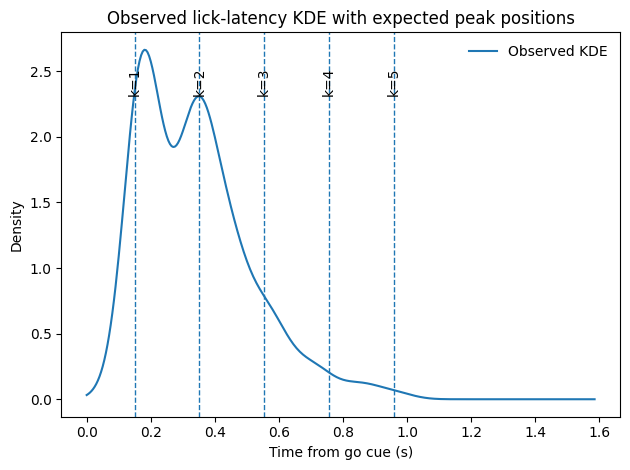

In [27]:
# === Expected-mode regression using RT_mode + (k-1)*Δt ===
# Works with your existing variables / pipeline, but is self-contained:
# - Computes RT_mode from movement-1 KDE (up to cue-response)
# - Uses your Δt and weights w_k (recomputed here)
# - Regresses expected peak positions vs k
# - Plots observed KDE + expected peak lines

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

def _check_cols(df, cols):
    miss = [c for c in cols if c not in df.columns]
    if miss:
        raise ValueError(f"Missing columns: {miss}")

def _kde_on_grid(samples: np.ndarray, grid: np.ndarray, bw=None) -> np.ndarray:
    samples = np.asarray(samples)
    if samples.size < 2 or np.std(samples) == 0:
        return np.zeros_like(grid, dtype=float)
    kde = gaussian_kde(samples, bw_method=bw)
    y = kde(grid)
    dx = grid[1] - grid[0] if len(grid) > 1 else 1.0
    s = y.sum() * dx
    return (y / s) if s > 0 else y

def expected_mode_regression(
    tongue_movements: pd.DataFrame,
    dx: float = 0.005,
    grid_min: float = None,
    grid_max: float = None,
    bw_rt=None
):
    """
    Returns:
      dict with rt_mode, delta_t, weights, expected_peaks (array), k_vals (array),
      regression {'slope','intercept','r2'}, and plotting grid+observed KDE.
    """
    _check_cols(tongue_movements, [
        'trial','movement_number_in_trial','movement_latency_from_go',
        'lick_latency','cue_response_movement_number'
    ])

    tm = tongue_movements.copy()
    for c in ['movement_number_in_trial','movement_latency_from_go','lick_latency','cue_response_movement_number']:
        tm[c] = pd.to_numeric(tm[c], errors='coerce')

    # Filter movements up to cue-response per trial (as you did earlier)
    mask = tm['cue_response_movement_number'].notna() & (
        tm['movement_number_in_trial'] <= tm['cue_response_movement_number']
    )
    tm_filt = tm[mask].copy()

    # RT samples (movement 1 latencies)
    rt = (tm_filt.query("movement_number_in_trial == 1")['movement_latency_from_go']
          .dropna().to_numpy())

    # Δt: median within-trial successive diffs (up to cue-response)
    diffs = []
    for _, sub in (tm_filt.dropna(subset=['movement_latency_from_go','movement_number_in_trial'])
                   .sort_values(['trial','movement_number_in_trial'])
                   .groupby('trial')):
        x = sub['movement_latency_from_go'].to_numpy()
        if x.size >= 2:
            d = np.diff(x)
            d = d[np.isfinite(d) & (d > 0)]
            if d.size:
                diffs.append(d)
    diffs = np.concatenate(diffs) if len(diffs) else np.array([])
    if diffs.size == 0:
        raise ValueError("No within-trial movement diffs found to estimate Δt.")
    delta_t = float(np.median(diffs))

    # Weights w_k from cue_response_movement_number (one per trial)
    cr_k = tm.drop_duplicates('trial')['cue_response_movement_number'].dropna().astype(int)
    if cr_k.empty:
        raise ValueError("No cue_response_movement_number values found.")
    max_k = int(cr_k.max())
    counts = cr_k.value_counts().sort_index()
    weights = {int(k): float(counts.get(k, 0)/counts.sum()) for k in range(1, max_k+1)}
    # Only keep non-zero weights
    k_vals = np.array([k for k, w in weights.items() if w > 0.0], dtype=int)

    # Grid for KDEs and plotting
    lick_lat = tm.drop_duplicates('trial')['lick_latency'].dropna().to_numpy()
    if grid_min is None:
        gmin = float(np.nanmin([lick_lat.min() if lick_lat.size else np.inf,
                                rt.min() if rt.size else np.inf, 0.0]))
    else:
        gmin = grid_min
    if grid_max is None:
        upper = []
        if lick_lat.size: upper.append(lick_lat.max())
        if rt.size:       upper.append(rt.max() + max(0, max_k-1)*delta_t)
        gmax = float(max(upper) if upper else 1.0)
    else:
        gmax = grid_max
    grid = np.arange(gmin, gmax + dx, dx)

    # Observed KDE on pooled lick latencies
    obs = lick_lat[np.isfinite(lick_lat) & (lick_lat >= gmin) & (lick_lat <= gmax)]
    obs_kde = _kde_on_grid(obs, grid)

    # RT KDE and mode (peak location)
    rt_kde = _kde_on_grid(rt, grid, bw=bw_rt)
    if np.allclose(rt_kde, 0):
        raise ValueError("RT KDE empty; not enough RT samples.")
    peaks, _ = find_peaks(rt_kde, prominence=0.0)
    if peaks.size == 0:
        # fall back to argmax
        rt_mode = float(grid[np.argmax(rt_kde)])
    else:
        # take the tallest peak in RT KDE
        tallest = peaks[np.argmax(rt_kde[peaks])]
        rt_mode = float(grid[tallest])

    # Expected peak locations: RT_mode + (k-1)*Δt
    expected_peaks = rt_mode + (k_vals - 1) * delta_t

    # Linear regression: expected_peak ~ k
    if k_vals.size >= 2:
        slope, intercept = np.polyfit(k_vals.astype(float), expected_peaks.astype(float), 1)
        yhat = slope * k_vals + intercept
        ss_res = float(np.sum((expected_peaks - yhat)**2))
        ss_tot = float(np.sum((expected_peaks - expected_peaks.mean())**2))
        r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    else:
        slope = np.nan; intercept = np.nan; r2 = np.nan

    out = {
        'rt_mode': rt_mode,
        'delta_t': delta_t,
        'weights': weights,
        'k_vals': k_vals,
        'expected_peaks': expected_peaks,
        'regression': {
            'slope': float(slope),
            'intercept': float(intercept),
            'r2': float(r2),
            # Add raw regression data here
            'x': k_vals.astype(float).tolist(),
            'y': expected_peaks.astype(float).tolist(),
            'yhat': yhat.tolist() if k_vals.size >= 2 else []
        },
        'grid': grid,
        'obs_kde': obs_kde
    }

    return out

# ---- run and plot ----
exp = expected_mode_regression(tongue_movements)

print(f"RT_mode (s): {exp['rt_mode']:.4f}")
print(f"Δt (median IMI, s): {exp['delta_t']:.4f}")
print("Weights w_k:", {k: round(exp['weights'][k], 3) for k in sorted(exp['weights'])})
print("k used:", exp['k_vals'])
print("Expected peak positions (s):", np.round(exp['expected_peaks'], 4))
print("Expected-mode regression (peak ~ k):", exp['regression'])
print(f"Δt vs slope difference (s): {exp['delta_t'] - exp['regression']['slope']:.4f}")

# Plot observed KDE with expected peak positions overlaid as vertical lines
fig, ax = plt.subplots()
ax.plot(exp['grid'], exp['obs_kde'], label="Observed KDE")
for k, x in zip(exp['k_vals'], exp['expected_peaks']):
    # vertical guide; no explicit color
    ax.axvline(x, linestyle='--', linewidth=1)
    ax.text(x, max(exp['obs_kde'])*0.95, f"k={k}", rotation=90, va='top', ha='center')
ax.set_xlabel("Time from go cue (s)")
ax.set_ylabel("Density")
ax.set_title("Observed lick-latency KDE with expected peak positions")
ax.legend(frameon=False)
fig.tight_layout()


In [28]:
exp['regression']


{'slope': 0.2019839999265969,
 'intercept': -0.05198399992659676,
 'r2': 1.0,
 'x': [1.0, 2.0, 3.0, 4.0, 5.0],
 'y': [0.15,
  0.3519839999265969,
  0.5539679998531938,
  0.7559519997797907,
  0.9579359997063875],
 'yhat': [0.15000000000000013,
  0.35198399992659707,
  0.553967999853194,
  0.7559519997797909,
  0.9579359997063879]}

In [11]:
def augment_trials_with_movement_summary(tongue_movements_annotated: pd.DataFrame,
                                         df_trials: pd.DataFrame) -> pd.DataFrame:
    """
    Adds trial-level columns to df_trials:
      • has_prelick_movement (boolean): any movement occurred before the cue-response movement
      • first_movement_latency_from_go (Float64): latency of the first movement from go cue
      • cue_response_movement_number (Int64): which movement number was the cue-response lick on
    """
    required = {
        'trial',
        'movement_number_in_trial',
        'cue_response_movement_number',
        'movement_before_cue_response',
        'movement_latency_from_go',
        'cue_response'
    }
    missing = required - set(tongue_movements_annotated.columns)
    if missing:
        raise ValueError(f"tongue_movements_annotated missing columns: {missing}")

    mv = tongue_movements_annotated.dropna(subset=['trial']).copy()

    # 1) Did any movement occur before the cue-response movement?
    prelick_by_trial = (
        mv.groupby('trial', sort=False)['movement_before_cue_response']
          .any()                  # True if any pre-lick movement in that trial
    )

    # 2) First movement latency from go (take the minimum non-null latency)
    first_latency_by_trial = (
        mv.groupby('trial', sort=False)['movement_latency_from_go']
          .min()                  # first movement after go has the smallest latency
    )

    # 3) Which movement number was the cue-response lick on?
    cue_move_num_by_trial = (
        mv.loc[mv['cue_response'] == True]
          .groupby('trial', sort=False)['movement_number_in_trial']
          .min()                  # there should be one per trial; min/first are equivalent
    )

    # Map onto trials
    trials_out = df_trials.copy()
    trials_out['has_prelick_movement'] = trials_out['trial'].map(prelick_by_trial)
    trials_out['first_movement_latency_from_go'] = trials_out['trial'].map(first_latency_by_trial)
    trials_out['cue_response_movement_number'] = trials_out['trial'].map(cue_move_num_by_trial)

    # Cast to nullable dtypes
    trials_out = trials_out.astype({
        'has_prelick_movement': 'boolean',
        'first_movement_latency_from_go': 'Float64',
        'cue_response_movement_number': 'Int64'
    })

    # Optional: if you prefer no NAs in the boolean, assume False when no movements are present
    trials_out['has_prelick_movement'] = trials_out['has_prelick_movement'].fillna(False)

    return trials_out


In [ ]:
# Add movement summary to trials dataframe
df_trials = augment_trials_with_movement_summary(tongue_movements, df_trials)


In [ ]:

def plot_endpoints_aligned_to_cue(
    tongue_movements: pd.DataFrame,
    axis='x',                 # 'x' or 'y' -> which endpoint dimension to plot
    n_pre=2,                  # show up to this many movements BEFORE cue-response (e.g., 2 -> m-2, m-1, m)
    jitter=0.08,              # horizontal jitter to avoid overplotting
    point_size=14,
    point_alpha=0.5,
    show_summary=True,        # overlay median and IQR per relative bin
    figsize=(7.5, 5.0),
):
    """
    Plot endpoint_x or endpoint_y against movement index aligned to the cue-response movement.
    X-axis: relative movement index (-n_pre ... -1, 0 where 0 = cue-response).
    Y-axis: endpoint_x or endpoint_y (absolute coordinates).

    Requires in tongue_movements:
      ['trial', 'movement_number_in_trial', 'cue_response_movement_number',
       'endpoint_x', 'endpoint_y']
    """
    if axis not in ('x', 'y'):
        raise ValueError("axis must be 'x' or 'y'")

    req = {'trial', 'movement_number_in_trial', 'cue_response_movement_number', 'endpoint_x', 'endpoint_y'}
    missing = req - set(tongue_movements.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df = tongue_movements.copy()

    # Keep rows with valid movement numbers and a defined cue-response index
    df = df.dropna(subset=['trial', 'movement_number_in_trial', 'cue_response_movement_number'])
    # Cast to ints safely (nullable Int64 -> int)
    df['movement_number_in_trial'] = df['movement_number_in_trial'].astype(int)
    df['cue_response_movement_number'] = df['cue_response_movement_number'].astype(int)

    # Relative index: 0 = cue-response move; negatives = steps before
    df['rel_move'] = df['movement_number_in_trial'] - df['cue_response_movement_number']

    # Keep only the window [ -n_pre .. 0 ]
    df = df[(df['rel_move'] <= 0) & (df['rel_move'] >= -n_pre)]

    # Pick which endpoint to plot
    ycol = 'endpoint_x' if axis == 'x' else 'endpoint_y'
    df = df.dropna(subset=[ycol])

    # Optional: ensure we only use trials where we actually have the cue-response row (rel_move==0)
    # so alignment is well-defined.
    cue_trials = set(df.loc[df['rel_move'] == 0, 'trial'].unique())
    df = df[df['trial'].isin(cue_trials)]

    # Prepare figure
    fig, ax = plt.subplots(figsize=figsize)

    # discrete x positions
    rel_bins = list(range(-n_pre, 0 + 1))
    x_positions = {k: i for i, k in enumerate(rel_bins)}

    # Scatter with jitter per relative bin
    rng = np.random.default_rng(0)
    for rel in rel_bins:
        g = df[df['rel_move'] == rel]
        if g.empty:
            continue
        x0 = x_positions[rel]
        xj = x0 + rng.uniform(-jitter, jitter, size=len(g))
        ax.scatter(xj, g[ycol], s=point_size, alpha=point_alpha, edgecolor='none', label=None)

    # Summary overlays (median + IQR whiskers as vertical bars)
    if show_summary:
        for rel in rel_bins:
            g = df[df['rel_move'] == rel][ycol]
            if len(g) == 0:
                continuea
            x0 = x_positions[rel]
            q1, med, q3 = np.percentile(g, [25, 50, 75])
            # IQR "box" as a thick line; whiskers to min/max within 1.5*IQR
            iqr = q3 - q1
            low = np.min(g[g >= q1 - 1.5 * iqr]) if len(g) else q1
            high = np.max(g[g <= q3 + 1.5 * iqr]) if len(g) else q3
            # IQR bar
            ax.plot([x0, x0], [q1, q3], linewidth=6, alpha=0.5)
            # median line
            ax.plot([x0 - 0.15, x0 + 0.15], [med, med], linewidth=2)
            # whiskers
            ax.plot([x0, x0], [low, high], linewidth=1)

    # Axes/labels
    ax.set_xticks([x_positions[r] for r in rel_bins], [str(r) for r in rel_bins])
    ax.set_xlim(-0.5, len(rel_bins) - 0.5)
    ax.set_xlabel("Movement index relative to cue-response (0 = cue response)")
    ax.set_ylabel(f"Endpoint {axis.upper()} (absolute)")
    ax.set_title(f"Endpoint {axis.upper()} vs. movement index (aligned to cue-response)")

    plt.tight_layout()
    return fig, ax


(<Figure size 750x500 with 1 Axes>,
 <Axes: title={'center': 'Endpoint Y vs. movement index (aligned to cue-response)'}, xlabel='Movement index relative to cue-response (0 = cue response)', ylabel='Endpoint Y (absolute)'>)

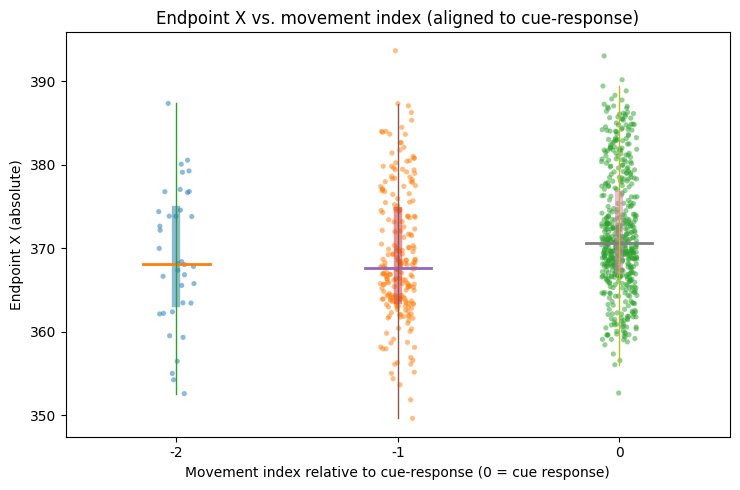

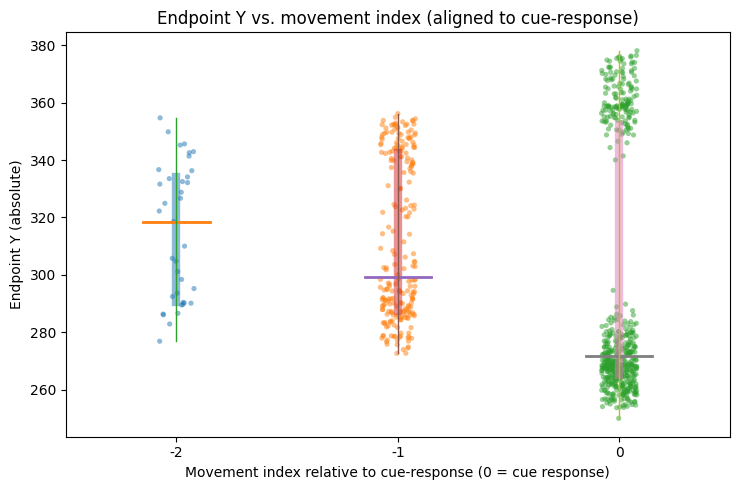

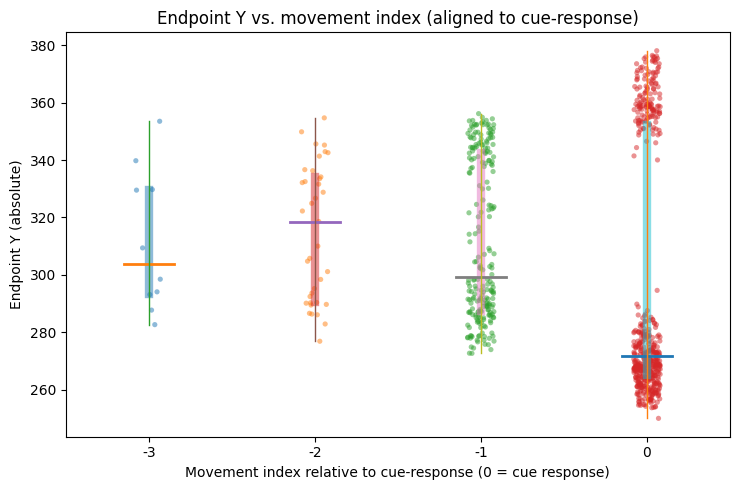

In [ ]:
# After you've run annotate_movement_timing(...)
# Show X endpoints
plot_endpoints_aligned_to_cue(tongue_movements, axis='x', n_pre=2)

# Show Y endpoints
plot_endpoints_aligned_to_cue(tongue_movements, axis='y', n_pre=2)

# If you want to look back further (e.g., 3 prior movements):
plot_endpoints_aligned_to_cue(tongue_movements, axis='y', n_pre=3)


In [ ]:


def plot_endpoints_aligned_to_cue(
    tongue_movements: pd.DataFrame,
    axis='x',                 # 'x' or 'y' -> which endpoint dimension to plot
    n_pre=2,                  # show up to this many movements BEFORE cue-response (e.g., 2 -> m-2, m-1, m)
    jitter=0.08,              # horizontal jitter to avoid overplotting
    point_size=14,
    point_alpha=0.5,
    line_alpha=0.15,          # transparency for connecting lines
    line_width=1.0,
    show_summary=True,        # overlay median and IQR per relative bin
    figsize=(7.5, 5.0),
):
    """
    Plot endpoint_x or endpoint_y against movement index aligned to the cue-response movement.
    X-axis: relative movement index (-n_pre ... -1, 0 where 0 = cue-response).
    Y-axis: endpoint_x or endpoint_y (absolute coordinates).

    Requires in tongue_movements:
      ['trial', 'movement_number_in_trial', 'cue_response_movement_number',
       'endpoint_x', 'endpoint_y']
    """
    if axis not in ('x', 'y'):
        raise ValueError("axis must be 'x' or 'y'")

    req = {'trial', 'movement_number_in_trial', 'cue_response_movement_number',
           'endpoint_x', 'endpoint_y'}
    missing = req - set(tongue_movements.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df = tongue_movements.copy()

    # Keep rows with valid movement numbers and a defined cue-response index
    df = df.dropna(subset=['trial', 'movement_number_in_trial', 'cue_response_movement_number'])
    df['movement_number_in_trial'] = df['movement_number_in_trial'].astype(int)
    df['cue_response_movement_number'] = df['cue_response_movement_number'].astype(int)

    # Relative index: 0 = cue-response move; negatives = steps before
    df['rel_move'] = df['movement_number_in_trial'] - df['cue_response_movement_number']

    # Keep only the window [ -n_pre .. 0 ]
    df = df[(df['rel_move'] <= 0) & (df['rel_move'] >= -n_pre)]

    # Pick which endpoint to plot
    ycol = 'endpoint_x' if axis == 'x' else 'endpoint_y'
    df = df.dropna(subset=[ycol])

    # Keep only trials where cue-response row exists
    cue_trials = set(df.loc[df['rel_move'] == 0, 'trial'].unique())
    df = df[df['trial'].isin(cue_trials)]

    # Prepare figure
    fig, ax = plt.subplots(figsize=figsize)

    # discrete x positions
    rel_bins = list(range(-n_pre, 0 + 1))
    x_positions = {k: i for i, k in enumerate(rel_bins)}

    rng = np.random.default_rng(0)

    # Scatter with jitter + connecting lines
    for trial, g in df.groupby('trial'):
        g = g.sort_values('rel_move')
        xs = []
        ys = []
        for _, row in g.iterrows():
            rel = row['rel_move']
            if rel not in x_positions:
                continue
            x0 = x_positions[rel]
            xj = x0 + rng.uniform(-jitter, jitter)
            xs.append(xj)
            ys.append(row[ycol])
            ax.scatter(xj, row[ycol], s=point_size, alpha=point_alpha,
                       edgecolor='none', color='C0')
        if len(xs) > 1:
            ax.plot(xs, ys, '-', color='C0', alpha=line_alpha, linewidth=line_width)

    # Summary overlays (median + IQR whiskers as vertical bars)
    if show_summary:
        for rel in rel_bins:
            g = df[df['rel_move'] == rel][ycol]
            if len(g) == 0:
                continue
            x0 = x_positions[rel]
            q1, med, q3 = np.percentile(g, [25, 50, 75])
            iqr = q3 - q1
            low = np.min(g[g >= q1 - 1.5 * iqr]) if len(g) else q1
            high = np.max(g[g <= q3 + 1.5 * iqr]) if len(g) else q3
            ax.plot([x0, x0], [q1, q3], linewidth=6, alpha=0.5, color='k')
            ax.plot([x0 - 0.15, x0 + 0.15], [med, med], linewidth=2, color='k')
            ax.plot([x0, x0], [low, high], linewidth=1, color='k')

    # Axes/labels
    ax.set_xticks([x_positions[r] for r in rel_bins], [str(r) for r in rel_bins])
    ax.set_xlim(-0.5, len(rel_bins) - 0.5)
    ax.set_xlabel("Movement index relative to cue-response (0 = cue response)")
    ax.set_ylabel(f"Endpoint {axis.upper()} (absolute)")
    ax.set_title(f"Endpoint {axis.upper()} vs. movement index (aligned to cue-response)")

    plt.tight_layout()
    return fig, ax


(<Figure size 750x500 with 1 Axes>,
 <Axes: title={'center': 'Endpoint Y vs. movement index (aligned to cue-response)'}, xlabel='Movement index relative to cue-response (0 = cue response)', ylabel='Endpoint Y (absolute)'>)

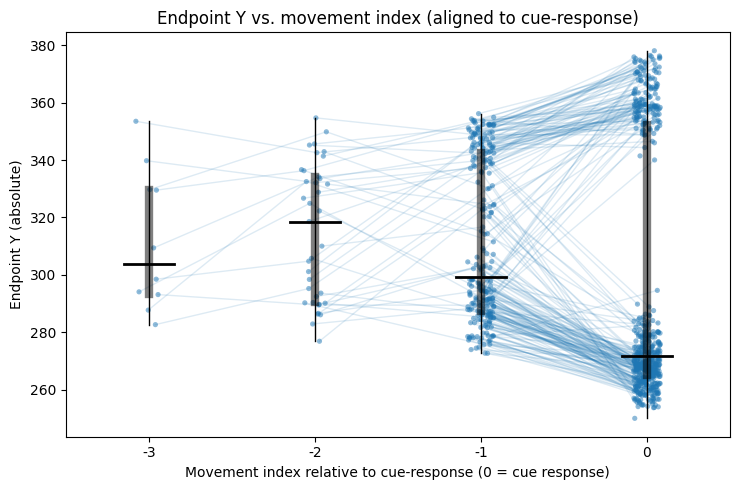

In [ ]:
plot_endpoints_aligned_to_cue(tongue_movements, axis='y', n_pre=3)


In [ ]:
session_folder

'/root/capsule/scratch/session_analysis_in_distribution/behavior_716325_2024-05-31_10-31-14'